In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
import geopandas as gpd
from scipy.stats import pearsonr

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import warnings
warnings.filterwarnings('ignore')

In [2]:
home_diversity = pd.read_pickle("./output/CA_CBG_dominantRace.pkl") #CBG level diversity
print(home_diversity.shape[0])
home_diversity = home_diversity[home_diversity['scaled_entropy'].notna()]
print(home_diversity.shape[0])
df_poi_CBG = pd.read_pickle('./output/LA_POI_belong_CBG.pkl') # each POI belongs to which CBG
df_poi_CBG_merged = pd.merge(df_poi_CBG,home_diversity,on='block_group_id')
df_poi_CBG_mergedneed = df_poi_CBG_merged[['place_id','scaled_entropy','class_dominant']]
df_poi_CBG_mergedneed.rename(columns={'scaled_entropy': 'home_scaled_entropy','class_dominant':'home_class_dominant'}, inplace=True)
df_poi_CBG_mergedneed # each POI's home based diversity

23212
23141


,place_id,home_scaled_entropy,home_class_dominant
0,25609839,0.096533,R_HispanicLatinx_low diversity
1,31157976,0.096533,R_HispanicLatinx_low diversity
2,27287495,0.096533,R_HispanicLatinx_low diversity
3,25590381,0.472712,R_HispanicLatinx_moderate diversity
4,25105312,0.472712,R_HispanicLatinx_moderate diversity
...,...,...,...
61963,31930253,0.312969,R_HispanicLatinx_low diversity
61964,25292594,0.289936,R_HispanicLatinx_low diversity
61965,25499120,0.562175,R_HispanicLatinx_moderate diversity
61966,25538751,0.762543,high diversity


# 1. proportion based entropy

In [16]:
weekday = False #False True
if weekday:
    diversity_morning = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_morning.pkl")  
    diversity_noon = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_noon.pkl")
    diversity_afternoon = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_afternoon.pkl")
    diversity_evening = pd.read_pickle("./output/LA_POI_diversity_202203_weekday_evening.pkl")
    print(diversity_morning.shape[0],diversity_noon.shape[0],diversity_afternoon.shape[0],diversity_evening.shape[0])
    title = 'Weekday'
else: #weekend
    diversity_morning = pd.read_pickle("./output/LA_POI_diversity_202203_weekend_morning.pkl")  
    diversity_noon = pd.read_pickle("./output/LA_POI_diversity_202203_weekend_noon.pkl")
    diversity_afternoon = pd.read_pickle("./output/LA_POI_diversity_202203_weekend_afternoon.pkl")
    diversity_evening = pd.read_pickle("./output/LA_POI_diversity_202203_weekend_evening.pkl")
    print(diversity_morning.shape[0],diversity_noon.shape[0],diversity_afternoon.shape[0],diversity_evening.shape[0])
    title = 'Weekend'

35039 40235 40034 33696


62490
61968
R_White_moderate diversity              18162
R_HispanicLatinx_moderate diversity     17267
R_HispanicLatinx_low diversity          8871 
high diversity                          8701 
R_Asian_moderate diversity              5034 
R_White_low diversity                   2101 
R_AfricanAmerican_moderate diversity    1127 
R_Asian_low diversity                   389  
R_AfricanAmerican_low diversity         192  
R_AmericanIndianAlaska_low diversity    99   
R_Other_moderate diversity              25   
Name: home_class_dominant, dtype: int64
61844
309220
208888


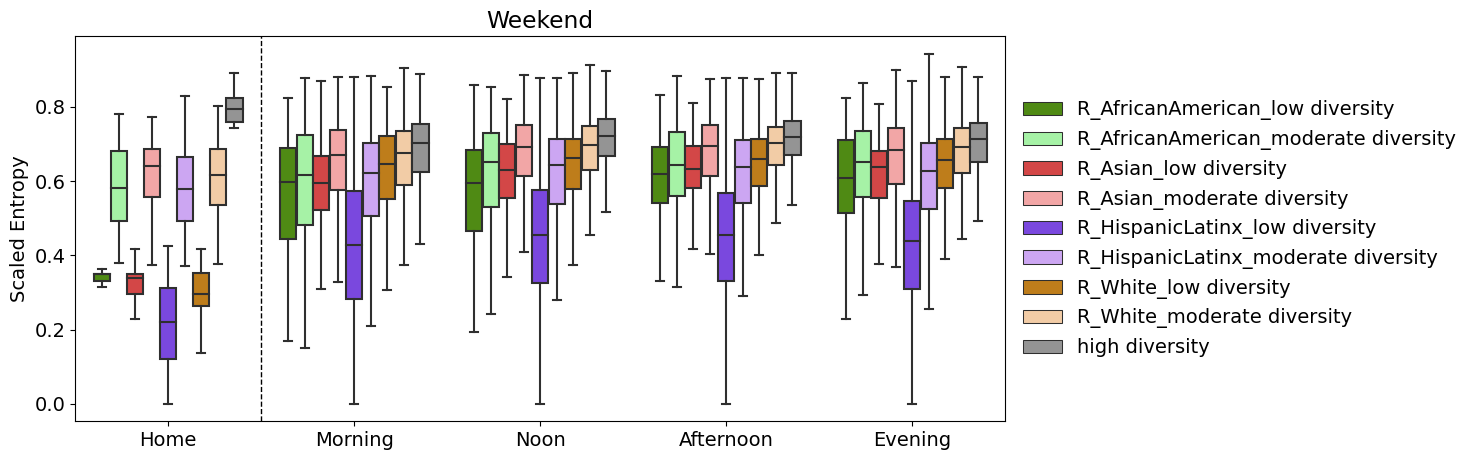

In [17]:
plt.rcParams.update({'font.size': 14})

diversity_morning3 = diversity_morning.rename(columns={'class_dominant':'morning_class_dominant','scaled_entropy':'1.morning'})
diversity_noon3 = diversity_noon.rename(columns={'class_dominant':'noon_class_dominant','scaled_entropy':'2.noon'})
diversity_afternoon3 = diversity_afternoon.rename(columns={'class_dominant':'afternoon_class_dominant','scaled_entropy':'3.afternoon'})
diversity_evening3 = diversity_evening.rename(columns={'class_dominant':'evening_class_dominant','scaled_entropy':'4.evening'})
#diversity_morning3, diversity_noon3, diversity_afternoon3, diversity_evening3

df_diversity_trend2 = pd.merge(df_poi_CBG_mergedneed,diversity_morning3[['place_id','morning_class_dominant','1.morning']],on='place_id',how='outer')
df_diversity_trend2 = pd.merge(df_diversity_trend2,diversity_noon3[['place_id','noon_class_dominant','2.noon']],on='place_id',how='outer')
df_diversity_trend2 = pd.merge(df_diversity_trend2,diversity_afternoon3[['place_id','afternoon_class_dominant','3.afternoon']],on='place_id',how='outer')
df_diversity_trend2 = pd.merge(df_diversity_trend2,diversity_evening3[['place_id','evening_class_dominant','4.evening']],on='place_id',how='outer')
df_diversity_trend2 = df_diversity_trend2.rename(columns={'home_scaled_entropy':'0.home'})

print(df_diversity_trend2.shape[0])
df_diversity_trend2 = df_diversity_trend2[df_diversity_trend2['home_class_dominant'].notna()]
print(df_diversity_trend2.shape[0])
print(df_diversity_trend2['home_class_dominant'].value_counts())
df_diversity_trend2 = df_diversity_trend2[~df_diversity_trend2['home_class_dominant'].isin(['R_AmericanIndianAlaska_low diversity','R_Other_moderate diversity'])]
print(df_diversity_trend2.shape[0])

df_diversity_melted = pd.melt(df_diversity_trend2, id_vars='home_class_dominant', 
                           value_vars=['0.home','1.morning', '2.noon', '3.afternoon', '4.evening'],
                           var_name='Value Type', value_name='Scaled Entropy')
print(df_diversity_melted.shape[0])
df_diversity_melted = df_diversity_melted[df_diversity_melted['Scaled Entropy'].notna()]
print(df_diversity_melted.shape[0])
df_diversity_melted = df_diversity_melted.sort_values(by=['home_class_dominant','Value Type'], ascending=True)
# df_diversity_melted.head()

my_colors = ["#4f9e00","#99ff99","#eb2f2f","#ff9999","#722ff7","#cc99ff","#d98200","#ffcc99","#949494"]
fig, ax = plt.subplots(figsize=(12,5))
sns.set_palette(my_colors)
ax = sns.boxplot(data=df_diversity_melted, x='Value Type', y='Scaled Entropy',hue='home_class_dominant', showfliers = False, orient="v")
ax.set(xlabel=None)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xticklabels(['Home','Morning','Noon','Afternoon','Evening'])#, fontsize=18
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.axvline(x=.5,linewidth=1, color='k',linestyle='--')
plt.title(title)
plt.show()


In [18]:
# df_diversity_trend2
print(df_diversity_melted.shape[0])
df_diversity_melted.groupby(['home_class_dominant','Value Type']).mean()

208888


Scaled Entropy
home_class_dominant                  Value Type                 
R_AfricanAmerican_low diversity      0.home       0.329736      
                                     1.morning    0.569533      
                                     2.noon       0.579893      
                                     3.afternoon  0.607855      
                                     4.evening    0.606399      
R_AfricanAmerican_moderate diversity 0.home       0.580719      
                                     1.morning    0.585255      
                                     2.noon       0.620078      
                                     3.afternoon  0.629737      
                                     4.evening    0.626361      
R_Asian_low diversity                0.home       0.318284      
                                     1.morning    0.592308      
                                     2.noon       0.619797      
                                     3.afternoon  0.626954      
                                     4.evening    0.612082      
R_Asian_moderate diversity           0.home       0.617265      
                                     1.morning    0.643698      
                                     2.noon       0.668830      
                                     3.afternoon  0.668367      
                                     4.evening    0.652443      
R_HispanicLatinx_low diversity       0.home       0.210576      
                                     1.morning    0.423138      
                                     2.noon       0.445971      
                                     3.afternoon  0.444129      
                                     4.evening    0.427599      
R_HispanicLatinx_moderate diversity  0.home       0.576197      
                                     1.morning    0.591294      
                                     2.noon       0.614696      
                                     3.afternoon  0.613205      
                                     4.evening    0.601093      
R_White_low diversity                0.home       0.294756      
                                     1.morning    0.625427      
                                     2.noon       0.637983      
                                     3.afternoon  0.641182      
                                     4.evening    0.639396      
R_White_moderate diversity           0.home       0.606268      
                                     1.morning    0.650102      
                                     2.noon       0.676932      
                                     3.afternoon  0.682506      
                                     4.evening    0.668353      
high diversity                       0.home       0.795013      
                                     1.morning    0.668913      
                                     2.noon       0.700419      
                                     3.afternoon  0.699045      
                                     4.evening    0.683961

In [19]:
df_diversity_melted[df_diversity_melted['Value Type']!='0.home'].groupby(['home_class_dominant']).mean()

,Scaled Entropy
home_class_dominant,
R_AfricanAmerican_low diversity,0.592460
R_AfricanAmerican_moderate diversity,0.615495
R_Asian_low diversity,0.613568
R_Asian_moderate diversity,0.658949
R_HispanicLatinx_low diversity,0.435909
R_HispanicLatinx_moderate diversity,0.605657
R_White_low diversity,0.636337
R_White_moderate diversity,0.670232
high diversity,0.689059


In [20]:
# df_diversity_trend2
print(df_diversity_melted.shape[0])
df_diversity_melted.groupby(['home_class_dominant','Value Type']).mean()

208888


Scaled Entropy
home_class_dominant                  Value Type                 
R_AfricanAmerican_low diversity      0.home       0.329736      
                                     1.morning    0.569533      
                                     2.noon       0.579893      
                                     3.afternoon  0.607855      
                                     4.evening    0.606399      
R_AfricanAmerican_moderate diversity 0.home       0.580719      
                                     1.morning    0.585255      
                                     2.noon       0.620078      
                                     3.afternoon  0.629737      
                                     4.evening    0.626361      
R_Asian_low diversity                0.home       0.318284      
                                     1.morning    0.592308      
                                     2.noon       0.619797      
                                     3.afternoon  0.626954      
                                     4.evening    0.612082      
R_Asian_moderate diversity           0.home       0.617265      
                                     1.morning    0.643698      
                                     2.noon       0.668830      
                                     3.afternoon  0.668367      
                                     4.evening    0.652443      
R_HispanicLatinx_low diversity       0.home       0.210576      
                                     1.morning    0.423138      
                                     2.noon       0.445971      
                                     3.afternoon  0.444129      
                                     4.evening    0.427599      
R_HispanicLatinx_moderate diversity  0.home       0.576197      
                                     1.morning    0.591294      
                                     2.noon       0.614696      
                                     3.afternoon  0.613205      
                                     4.evening    0.601093      
R_White_low diversity                0.home       0.294756      
                                     1.morning    0.625427      
                                     2.noon       0.637983      
                                     3.afternoon  0.641182      
                                     4.evening    0.639396      
R_White_moderate diversity           0.home       0.606268      
                                     1.morning    0.650102      
                                     2.noon       0.676932      
                                     3.afternoon  0.682506      
                                     4.evening    0.668353      
high diversity                       0.home       0.795013      
                                     1.morning    0.668913      
                                     2.noon       0.700419      
                                     3.afternoon  0.699045      
                                     4.evening    0.683961

In [21]:
df_diversity_melted[df_diversity_melted['Value Type']!='0.home'].groupby(['home_class_dominant']).mean()

,Scaled Entropy
home_class_dominant,
R_AfricanAmerican_low diversity,0.592460
R_AfricanAmerican_moderate diversity,0.615495
R_Asian_low diversity,0.613568
R_Asian_moderate diversity,0.658949
R_HispanicLatinx_low diversity,0.435909
R_HispanicLatinx_moderate diversity,0.605657
R_White_low diversity,0.636337
R_White_moderate diversity,0.670232
high diversity,0.689059


# 2. weighted entropy (don't run)

In [40]:
#2. duration weighted entropy
weekday = False

if weekday:
    durdiversity_morning = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_morning.pkl")  
    durdiversity_noon = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_noon.pkl")  
    durdiversity_afternoon = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_afternoon.pkl")  
    durdiversity_evening = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekday_evening.pkl")  
    print(durdiversity_morning.shape[0],durdiversity_noon.shape[0],durdiversity_afternoon.shape[0],durdiversity_evening.shape[0])
    title = 'Weekday'
else: #weekend    
    durdiversity_morning = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekend_morning.pkl")  
    durdiversity_noon = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekend_noon.pkl")  
    durdiversity_afternoon = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekend_afternoon.pkl")  
    durdiversity_evening = pd.read_pickle("./output/LA_POI_durationbased_diversity_202203_weekend_evening.pkl")  
    print(durdiversity_morning.shape[0],durdiversity_noon.shape[0],durdiversity_afternoon.shape[0],durdiversity_evening.shape[0])
    title = 'Weekend'    

35040 40235 40038 33744


62490
61968
R_White_moderate diversity              18162
R_HispanicLatinx_moderate diversity     17267
R_HispanicLatinx_low diversity          8871 
high diversity                          8701 
R_Asian_moderate diversity              5034 
R_White_low diversity                   2101 
R_AfricanAmerican_moderate diversity    1127 
R_Asian_low diversity                   389  
R_AfricanAmerican_low diversity         192  
R_AmericanIndianAlaska_low diversity    99   
R_Other_moderate diversity              25   
Name: home_class_dominant, dtype: int64
61844
309220
208936


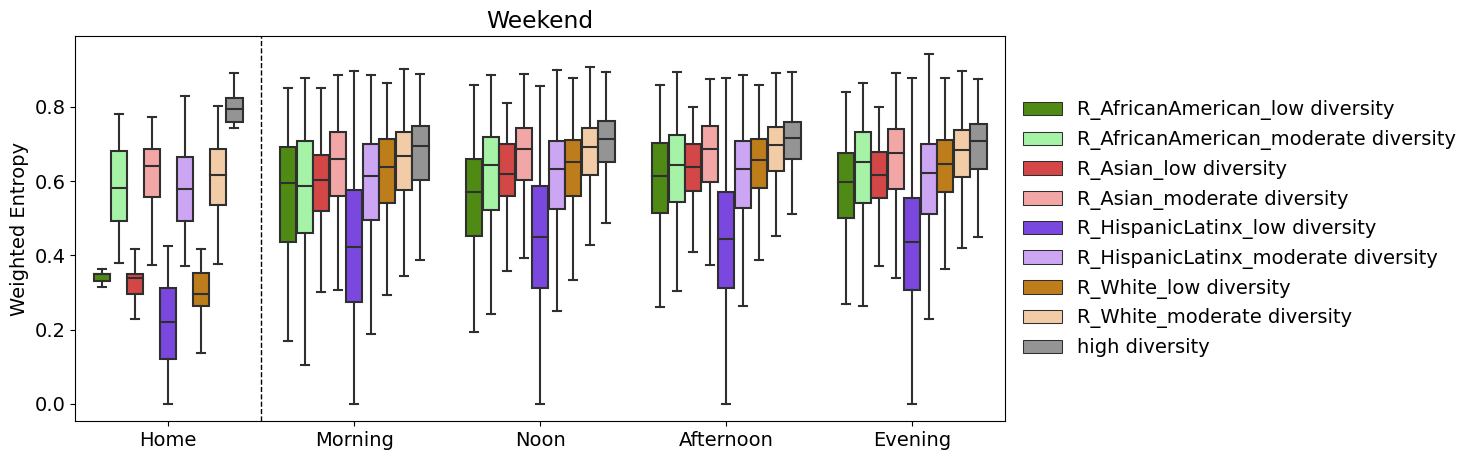

In [41]:
diversity_morning3 = durdiversity_morning.rename(columns={'class_dominant':'morning_class_dominant','scaled_entropy':'1.morning'})
diversity_noon3 = durdiversity_noon.rename(columns={'class_dominant':'noon_class_dominant','scaled_entropy':'2.noon'})
diversity_afternoon3 = durdiversity_afternoon.rename(columns={'class_dominant':'afternoon_class_dominant','scaled_entropy':'3.afternoon'})
diversity_evening3 = durdiversity_evening.rename(columns={'class_dominant':'evening_class_dominant','scaled_entropy':'4.evening'})

df_diversity_trend2 = pd.merge(df_poi_CBG_mergedneed,diversity_morning3[['place_id','morning_class_dominant','1.morning']],on='place_id',how='outer')
df_diversity_trend2 = pd.merge(df_diversity_trend2,diversity_noon3[['place_id','noon_class_dominant','2.noon']],on='place_id',how='outer')
df_diversity_trend2 = pd.merge(df_diversity_trend2,diversity_afternoon3[['place_id','afternoon_class_dominant','3.afternoon']],on='place_id',how='outer')
df_diversity_trend2 = pd.merge(df_diversity_trend2,diversity_evening3[['place_id','evening_class_dominant','4.evening']],on='place_id',how='outer')
df_diversity_trend2 = df_diversity_trend2.rename(columns={'home_scaled_entropy':'0.home'})

print(df_diversity_trend2.shape[0])
df_diversity_trend2 = df_diversity_trend2[df_diversity_trend2['home_class_dominant'].notna()]
print(df_diversity_trend2.shape[0])
print(df_diversity_trend2['home_class_dominant'].value_counts())
df_diversity_trend2 = df_diversity_trend2[~df_diversity_trend2['home_class_dominant'].isin(['R_AmericanIndianAlaska_low diversity','R_Other_moderate diversity'])]
print(df_diversity_trend2.shape[0])

df_diversity_melted = pd.melt(df_diversity_trend2, id_vars='home_class_dominant', 
                           value_vars=['0.home','1.morning', '2.noon', '3.afternoon', '4.evening'],
                           var_name='Value Type', value_name='Weighted Entropy')
print(df_diversity_melted.shape[0])
df_diversity_melted = df_diversity_melted[df_diversity_melted['Weighted Entropy'].notna()]
print(df_diversity_melted.shape[0])
df_diversity_melted = df_diversity_melted.sort_values(by=['home_class_dominant','Value Type'], ascending=True)


my_colors = ["#4f9e00","#99ff99","#eb2f2f","#ff9999","#722ff7","#cc99ff","#d98200","#ffcc99","#949494"]
fig, ax = plt.subplots(figsize=(12,5))
sns.set_palette(my_colors)
ax = sns.boxplot(data=df_diversity_melted, x='Value Type', y='Weighted Entropy',hue='home_class_dominant', showfliers = False, orient="v")
ax.set(xlabel=None)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_xticklabels(['Home','Morning','Noon','Afternoon','Evening'])#, fontsize=18
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
plt.axvline(x=.5,linewidth=1, color='k',linestyle='--')
plt.title(title)
plt.show()